# 9.2 Censored Data and the Kaplan-Meier Estimate

### Setup

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import special

In [3]:
ncog = pd.read_csv("../data/ncog.txt", delimiter=" ")
ncog.sort_values(["arm", "t"], inplace=True)
ncog.reset_index(drop=True, inplace=True)

In [4]:
ncog.head()

,day,month,year,t,d,arm
0,5,2,81,7,1,A
1,30,11,82,34,1,A
2,27,9,83,42,1,A
3,9,5,80,63,1,A
4,23,4,81,64,1,A


### Add data columns

The following creates separate subsets of the dataset for arm A and arm B and groups by month to count the number of deaths and loss to followup in each month

In [5]:
ncog["month_in_study"] = (ncog.t / (365 / 12)).astype("int") + 1

In [6]:
ncog_a_temp = ncog.loc[ncog.arm == "A"]
ncog_b_temp = ncog.loc[ncog.arm == "B"]

In [7]:
ncog_a_temp = ncog_a_temp.groupby("month_in_study").agg(
    {"t": "count", "d": "sum"}
).rename(columns={"t": "n_events", "d": "y"})

ncog_b_temp = ncog_b_temp.groupby("month_in_study").agg(
    {"t": "count", "d": "sum"}
).rename(columns={"t": "n_events", "d": "y"})

In [8]:
ncog_a_temp["l"] = ncog_a_temp.n_events - ncog_a_temp.y
ncog_b_temp["l"] = ncog_b_temp.n_events - ncog_b_temp.y

In [9]:
ncog_a_temp.tail()

,n_events,y,l
month_in_study,,,
37,2,1,1
38,1,1,0
41,1,0,1
45,1,0,1
47,2,1,1


The `ncog_a_temp` and `ncog_b_temp` are missing months where there were no events. We'll create new DataFrames with missing months filled in.

The following function loops through a `_temp` DataFrame, making the rows of Table 9.3 by keeping track of `n` and filling in rows without events.

In [10]:
def fillmonths(dfin):
    data = np.zeros((dfin.index.max(), 4), dtype="int")

    n = dfin.n_events.sum()
    y = dfin.y.values
    l = dfin.l.values

    prev_month = 0
    i = 0
    while i < dfin.shape[0]:
        month = dfin.index[i]
        # fill in missing months
        while month != prev_month + 1:
            prev_month += 1
            data[prev_month - 1, :] = [prev_month, n, 0, 0]
        yval = y[i]
        lval = l[i]
        data[month - 1, :] = (month, n, yval, lval)
        prev_month = month
        n -= (yval + lval)
        i += 1
    
    return pd.DataFrame(data, columns=["Month", "n", "y", "l"])

In [11]:
ncog_months_a = fillmonths(ncog_a_temp)
ncog_months_b = fillmonths(ncog_b_temp)

In [12]:
ncog_months_a.tail()

,Month,n,y,l
42,43,3,0,0
43,44,3,0,0
44,45,3,0,1
45,46,2,0,0
46,47,2,1,1


Add $\hat{h}$ and $\hat{S}$

In [13]:
ncog_months_a["h_hat"] = ncog_months_a.y / ncog_months_a.n
ncog_months_b["h_hat"] = ncog_months_b.y / ncog_months_b.n

In [14]:
def s_hat(h_hat):
    s = 1
    svals = []
    for hval in h_hat:
        s *= (1 - hval)
        svals.append(s)
    return svals

In [15]:
ncog_months_a["S_hat"] = s_hat(ncog_months_a.h_hat)
ncog_months_b["S_hat"] = s_hat(ncog_months_b.h_hat)

We'll need these datasets again in the next section

In [16]:
ncog_months_a.to_csv("../data/ncog_months_a.csv", index=False)
ncog_months_b.to_csv("../data/ncog_months_b.csv", index=False)

### Table 9.3

In [17]:
ncog_months_a.set_index("Month").round(3)

,n,y,l,h_hat,S_hat
Month,,,,,
1,51,1,0,0.020,0.980
2,50,2,0,0.040,0.941
3,48,5,1,0.104,0.843
4,42,2,0,0.048,0.803
5,40,8,0,0.200,0.642
6,32,7,0,0.219,0.502
7,25,0,1,0.000,0.502
8,24,3,0,0.125,0.439
9,21,2,0,0.095,0.397


### Figure 9.1

In [18]:
def kaplan_meier(events):
    events = sorted(events)
    svals = []
    tvals = []
    s = 1
    n = len(events)
    for k, (t, d) in enumerate(events, 1):
        if d == 1:
            s *= (n - k) / (n - k + 1)
        svals.append(s)
        tvals.append(t)
    return svals, tvals

In [19]:
ncog_arm_a = ncog.loc[ncog.arm == "A"]
ncog_arm_b = ncog.loc[ncog.arm == "B"]

events_a = list(zip(ncog_arm_a.t, ncog_arm_a.d))
events_b = list(zip(ncog_arm_b.t, ncog_arm_b.d))

svals_a, tvals_a = kaplan_meier(events_a)
svals_b, tvals_b = kaplan_meier(events_b)

In [20]:
def greenwood_ci(svals, events, sd_time):
    events = sorted(events)
    summand = 0
    n = len(events)
    n_deaths = 0
    for k, (t, d) in enumerate(events):
        if t >= sd_time:
            break
        if d == 1:
            n_deaths += 1
            summand += 1 / ((n - k) * (n - k - 1))
    sj = svals[k - 1]
    lo = np.exp(np.log(sj) - 1.96 * np.sqrt(summand))
    hi = np.exp(np.log(sj) + 1.96 * np.sqrt(summand))
    return lo, hi

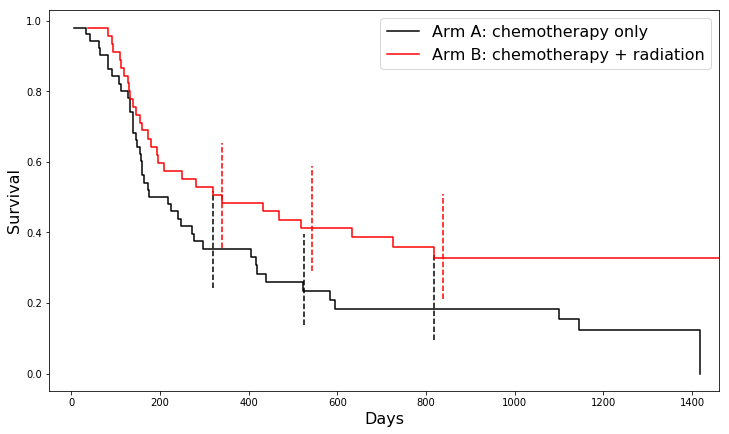

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(
    tvals_a,
    svals_a,
    drawstyle="steps-post",
    c="k",
    label="Arm A: chemotherapy only"
)
for t in [320, 524, 818]:
    lo, hi = greenwood_ci(svals_a, events_a, t)
    ax.plot([t, t], [lo, hi], c="k", linestyle="--")

ax.plot(
    tvals_b,
    svals_b,
    drawstyle="steps-post",
    c="r",
    label="Arm B: chemotherapy + radiation"
)
for t in [340, 544, 838]:
    lo, hi = greenwood_ci(svals_b, events_b, t)
    ax.plot([t, t], [lo, hi], c="r", linestyle="--")

ax.legend(fontsize=16)
ax.set_xlabel("Days", size=16)
ax.set_ylabel("Survival", size=16)

ax.set_xlim(-50, 1460);

I'm not entirely certain that the intervals are calculated correctly, but they look pretty good